## STAR-RIS Aided Multi-Cell NOMA

### Necessary Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import rayleigh, rice

plt.style.use("default")
plt.rcParams["figure.figsize"] = (6, 4)

### System Model

Parameters

In [2]:
# multi-cell NOMA
N = 3  # Number of users
N_index = np.arange(N)  # Index of users
M = 2  # Number of BSs
M_index = np.arange(M)  # Index of BSs
AREA = 500  # Area of the simulation m^2
ETA = 4  # path loss exponent
BANDWIDTH = 1e6  # bandwidth in Hz
NOISE = -150 + 10 * np.log10(BANDWIDTH)  # noise power in dBm
NOISE_LIN = 10 ** (NOISE / 10) / 1000  # noise power in linear scale
K = 5 * 10**4  # number of bits to be transmitted

# power parameters
Pt = np.linspace(-30, 30, 60)  # transmit power in dBm
Pt_lin = 10 ** (Pt / 10) / 1000  # transmit power in linear scale
P_circuit = 1e-2  # circuit power in Watts

Creating Layout

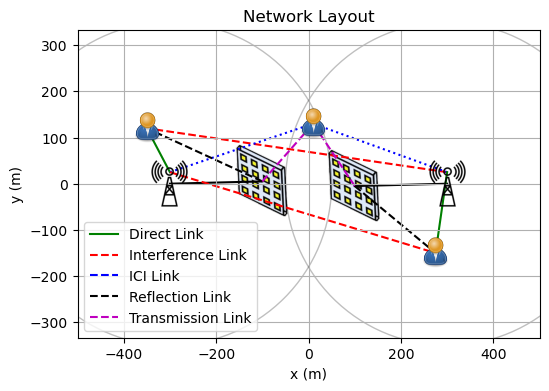

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.image import imread

# placing the base stations
bs_pos = np.array([[-300, 0], [300, 0]])
user_pos = np.array([[-350, 120], [10, 130], [275, -150]])
ris_pos = np.array([[-100, 5], [100, -5]])

# plotting the layout
fig, ax = plt.subplots(figsize=(6, 4))
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.xlim([-AREA, AREA])
plt.ylim([-AREA / 1.5, AREA / 1.5])
plt.grid()

for bs in bs_pos:
    circle = Circle(bs, radius=350, fill=False, alpha=0.25)
    ax.add_patch(circle)
    bs_img = imread("../resources/bs.png")
    plt.imshow(
        bs_img, extent=[bs[0] - 40, bs[0] + 40, bs[1] - 50, bs[1] + 50], zorder=2
    )

for i, bs in enumerate(bs_pos):
    for j, ris in enumerate(ris_pos):
        if i == j:
            plt.plot([bs[0], ris[0]], [bs[1], ris[1]], "k-", zorder=1)

for user in user_pos:
    for bs in bs_pos:
        if np.linalg.norm(user - bs) == np.min(np.linalg.norm(user_pos - bs, axis=1)):
            plt.plot([bs[0], user[0]], [bs[1] + 25, user[1]], "g-", zorder=1)
        else:
            if (user == user_pos[1]).all():
                plt.plot([bs[0], user[0]], [bs[1] + 25, user[1]], "b:", zorder=1)
            else:
                plt.plot([bs[0], user[0]], [bs[1] + 25, user[1]], "r--", zorder=1)
    user_img = imread("../resources/user.png")
    plt.imshow(
        user_img,
        extent=[user[0] - 35, user[0] + 35, user[1] - 35, user[1] + 35],
        zorder=2,
    )

for ris in ris_pos:
    ris_img = imread("../resources/starris.png")
    plt.imshow(
        ris_img, extent=[ris[0] - 60, ris[0] + 60, ris[1] - 80, ris[1] + 80], zorder=0
    )

for i, ris in enumerate(ris_pos):
    for j, user in enumerate(user_pos):
        if j == 0 and i == 0:
            plt.plot([ris[0], user[0]], [ris[1], user[1]], "k--", zorder=1)
        elif j == 1 and (i == 0 or i == 1):
            plt.plot([ris[0], user[0]], [ris[1], user[1]], "m--", zorder=1)
        elif j == 2 and i == 1:
            plt.plot([ris[0], user[0]], [ris[1], user[1]], "k--", zorder=1)

plt.plot([], [], "g-", label="Direct Link", zorder=1)
plt.plot([], [], "r--", label="Interference Link", zorder=1)
plt.plot([], [], "b--", label="ICI Link", zorder=1)
plt.plot([], [], "k--", label="Reflection Link", zorder=1)
plt.plot([], [], "m--", label="Transmission Link", zorder=1)

plt.title("Network Layout")
plt.legend()
plt.show()

### System Matrices

In [4]:
# find distances between users and base stations
distance_mat = np.sqrt(np.sum((user_pos[:, np.newaxis, :] - bs_pos) ** 2, axis=-1))

# generate channel coefficients
h = np.zeros((N, M, K // 2), dtype=np.complex128)

for i in range(M):
    for j in range(N):
        h[j, i, :] = (
            np.sqrt(distance_mat[j, i] ** (-ETA))
            * (np.random.randn(K // 2) + 1j * np.random.randn(K // 2))
            / np.sqrt(2)
        )

# find the channel gains
g = np.abs(h) ** 2

print("Gain Matrix:")
print(g.mean(axis=2))

Gain Matrix:
[[3.47649651e-09 5.26072541e-12]
 [1.23601696e-10 1.22665655e-10]
 [8.05579841e-12 1.86345907e-09]]


In [5]:
# generating noise
noise_mat = np.sqrt(NOISE_LIN / 2) * (
    np.random.randn(N, M, K // 2) + 1j * np.random.randn(N, M, K // 2)
)

print("Noise:")
print(noise_mat)

Noise:
[[[ 2.92296174e-08-1.27456783e-06j  6.78013181e-07-1.04407924e-06j
   -9.07307441e-07-5.40528486e-07j ...  2.51234877e-07+5.84914368e-07j
   -4.36111752e-07-2.17446825e-07j -3.53069828e-07-9.23686415e-08j]
  [-1.45610464e-07-6.51174475e-07j  7.50695690e-07-3.88042358e-07j
   -2.39030075e-07-1.08117118e-07j ... -2.19799612e-06-2.55572845e-07j
    1.10528718e-07-6.89903133e-07j -2.97475663e-07+4.31511695e-07j]]

 [[-9.41621785e-08-8.95439097e-08j -1.95876888e-07-1.68497807e-07j
    2.73131875e-07-7.02391541e-08j ... -4.92814335e-07-6.07385310e-07j
    2.19390138e-07+1.50543959e-06j -4.51964578e-07-2.99107573e-07j]
  [-9.51687663e-08-1.36462293e-07j -1.04941770e-07-3.61348655e-07j
   -6.77965324e-07-5.57589450e-07j ... -2.26229429e-07-1.26568140e-06j
    1.13909663e-07-1.23309086e-07j -3.93209113e-07-1.74604945e-07j]]

 [[-8.75788949e-07+1.76398833e-07j -6.42138690e-07-1.20322987e-06j
    1.09439255e-06-2.18857444e-07j ... -6.00918418e-07+7.37704803e-07j
    9.59986184e-07+3.329510

### Power Allocation Factor

In [6]:
# assigning alpha factors for fixed allocation
alpha = np.zeros((N - 1, M))
alpha[:, 0] = (0.3, 0.7)
alpha[:, 1] = (0.7, 0.3)

print("Fixed Allocation Alpha:")
print(alpha)

Fixed Allocation Alpha:
[[0.3 0.7]
 [0.7 0.3]]


### Analysis

In [7]:
rate = np.zeros((N, K // 2))
user_rate = np.zeros((N, len(Pt_lin)))
sum_rate = np.zeros(len(Pt_lin))
outage = np.zeros((N, len(Pt_lin)))
r_min = 1
energy_eff = np.zeros(len(Pt_lin))
spectral_eff = np.zeros(len(Pt_lin))

for i in range(len(Pt_lin)):
    # rate for user 1
    rate[0, :] = np.log2(
        1
        + Pt_lin[i]
        * alpha[0, 0]
        * g[0, 0, :]
        / (NOISE_LIN + Pt_lin[i] * alpha[0, 0] * g[0, 1, :])
    )

    # rate for user 2
    rate[1, :] = np.log2(
        1
        + Pt_lin[i]
        * (alpha[0, 1] * g[1, 0, :] + alpha[1, 0] * g[1, 1, :])
        / (
            Pt_lin[i] * alpha[0, 0] * g[1, 0, :]
            + Pt_lin[i] * alpha[1, 1] * g[1, 1, :]
            + NOISE_LIN
        )
    )

    # rate for user 3
    rate[2, :] = np.log2(
        1
        + Pt_lin[i]
        * alpha[1, 1]
        * g[2, 1, :]
        / (NOISE_LIN + Pt_lin[i] * alpha[1, 1] * g[2, 0, :])
    )

    # sum rate
    user_rate[0, i] = np.mean(rate[0, :])
    user_rate[1, i] = np.mean(rate[1, :])
    user_rate[2, i] = np.mean(rate[2, :])
    sum_rate[i] = np.sum(np.mean(rate, axis=1))

    # outage probability
    for k in range(K // 2):
        if rate[0, k] < r_min:
            outage[0, i] += 1
        if rate[1, k] < r_min:
            outage[1, i] += 1
        if rate[2, k] < r_min:
            outage[2, i] += 1

    # SE-EE tradeoff
    spectral_eff[i] = sum_rate[i]  # already normalized by bandwidth
    energy_eff[i] = sum_rate[i] / (Pt_lin[i] + P_circuit)

outage /= K // 2

### Plots

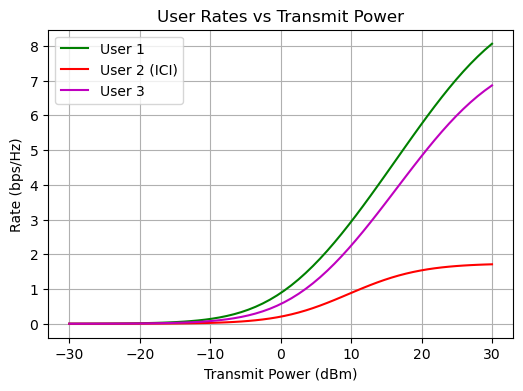

In [8]:
# user rates vs transmit power
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(Pt, user_rate[0, :], "g-", label="User 1")
plt.plot(Pt, user_rate[1, :], "r-", label="User 2 (ICI)")
plt.plot(Pt, user_rate[2, :], "m-", label="User 3")
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Rate (bps/Hz)")
plt.title("User Rates vs Transmit Power")
plt.legend()
plt.grid()
plt.show()

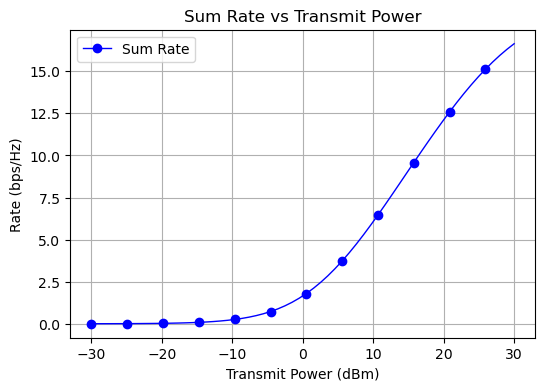

In [9]:
# sum rate vs transmit power
fig = plt.figure(figsize=(6, 4))
plt.plot(Pt, sum_rate, "b-", label="Sum Rate", linewidth=1, marker="o", markevery=5)
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Rate (bps/Hz)")
plt.title("Sum Rate vs Transmit Power")
plt.legend()
plt.grid()
plt.show()

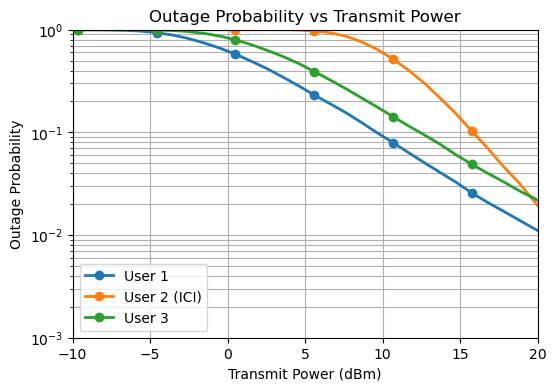

In [10]:
# outage probability vs transmit power
fig, ax = plt.subplots(figsize=(6, 4))
plt.semilogy(Pt, outage[0, :], label="User 1", marker="o", linewidth=2, markevery=5)
plt.semilogy(
    Pt, outage[1, :], label="User 2 (ICI)", marker="o", linewidth=2, markevery=5
)
plt.semilogy(Pt, outage[2, :], label="User 3", marker="o", linewidth=2, markevery=5)
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Outage Probability")
plt.title("Outage Probability vs Transmit Power")
plt.xlim([-10, 20])
plt.ylim([1e-3, 1])
plt.legend()
plt.grid(which="both")
plt.show()

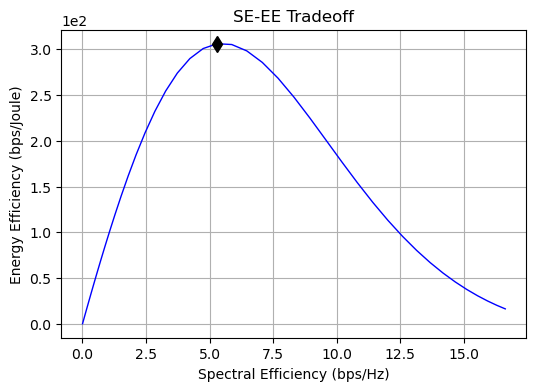

In [11]:
# SE-EE tradeoff
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(spectral_eff, energy_eff, "b-", linewidth=1)
plt.xlabel("Spectral Efficiency (bps/Hz)")
plt.ylabel("Energy Efficiency (bps/Joule)")
plt.title("SE-EE Tradeoff")
plt.grid()

# Find the peak point
peak_idx = np.argmax(energy_eff)
peak_x = spectral_eff[peak_idx]
peak_y = energy_eff[peak_idx]

# Add a marker at the peak point
plt.plot(peak_x, peak_y, marker="d", markersize=8, color="black")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.show()